In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime

from IPython.display import display, HTML
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15

#tnrfont = {'family':'serif','serif':['Times New Roman']}
#mpl.rc('font',**{'family':'serif','serif':['Times']})



def geoconv(xdata, ydata, lat0, lon0):
    #takes flattened xy-grid data, where lat0-lon0 is the origin, and converts to flattened array of lat-lon via equirectangular projection
    R_e = 6371.
    lon0, lat0 = map(np.radians, [lon0, lat0])
    lat1 = lat0 + ydata/R_e
    avglat = (lat0 + lat1)/2.
    lon1 = lon0 + xdata/(R_e*np.cos(avglat))
    lon1, lat1 = map(np.degrees, [lon1, lat1])
    return lat1, lon1

def haversine(lat1, lon1, lat2, lon2):
    #Computes the great-circle distance (km) between two lat-lon points (dec. deg)
    #M. Dunn# 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2.)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.)**2
    c = 2. * np.arcsin(np.sqrt(a)) 
    R_e = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * R_e

def nphaversine(lat1, lon1, lat2, lon2):
    #Computes the great-circle distance (km) between two lat-lon points (dec. deg)
    #adjusted to vectorize and simplify the geo-clustering computation; need lat1 and lon1 as nx1 matrices and lat2, lon2 as 1xm
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.square(np.sin(dlat/2.)) + np.multiply(np.outer(np.cos(lat1),np.cos(lat2)),np.square(np.sin(dlon/2.)))
    c = 2 * np.arcsin(np.sqrt(a)) 
    R_e = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * R_e

def disttest(a,b,x,y):
    return np.sqrt(np.square(a-x)+np.square(b-y))

def cdens(londata, latdata, lon0, lat0):
    #Computes the normalized commuter density for a given source/sink point (units:km^-1)
    #xdata/ydata: flattened arrays with coordinates of x/y grid; x0/y0: current source point/station
    kw = 1/1.6; kb = 1/2.5; aw = 3/4.; ab = 1/8.; at = 1/8.;
    r = haversine(latdata, londata, lat0, lon0)
    sigt = (2/3.*np.log(4.2/1.6))**0.5
    mut = 2/3.*np.log(4.2) + 1/3.*np.log(1.6)
    #current model includes exponential distributions for walkers and cyclists and a log-normal for taxis
    g = aw*kw*np.exp(-kw*r) + ab*kb*np.exp(-kb*r) + np.sign(r)*at/(r*sigt*(2*np.pi)**0.5)*np.exp(-0.5*((np.log(r)-mut)/sigt)**2)
    return g/(2*np.pi)
   

#Center of the universe!
dslat = 41.882692
dslon = -87.626146


In [2]:
#loading 'L' data and geo data
Ldata = pd.read_csv('C:/ML/DSchallenge/Lentries.csv')
Ldata = Ldata.assign(lat = 0, lon = 0)
Ldata['date'] = pd.to_datetime(Ldata['date'], format = "%m/%d/%Y")
geodata = pd.read_csv('C:/ML/DSChallenge/StopList.csv')
latlon = geodata.loc[:,['MAP_ID','Location']]

#stripping out parentheses
latlon['Location'] = latlon['Location'].map(lambda x: x.lstrip('(').rstrip(')'))

In [3]:
#splitting lat and lon into new columns
####  C. Albon ####
lat = []
lon = []

for row in latlon['Location']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)
        
latlon['lat'] = lat
latlon['lon'] = lon
latlon.drop('Location', axis=1, inplace=True)
####

#converting extracted lat-lon to num
latlon[['lat','lon']] = latlon[['lat','lon']].apply(pd.to_numeric)

latdict = dict(zip(latlon.MAP_ID, latlon.lat))
londict = dict(zip(latlon.MAP_ID, latlon.lon))
Ldata['lat'] = Ldata['station_id'].map(latdict)
Ldata['lon'] = Ldata['station_id'].map(londict)


#Filter out any stations without geographic coordinates
Ldata = Ldata[Ldata['lat'].notnull() & (Ldata['lon'].notnull())]

print("L-entry data:")
display(Ldata.head(2))
print("geo data for stations:")
display(latlon.head(2))

L-entry data:


,station_id,stationname,date,daytype,rides,lat,lon
2,40030,Pulaski-Lake,2001-01-01,U,483,41.885412,-87.725404
3,40040,Quincy/Wells,2001-01-01,U,374,41.878723,-87.633740


geo data for stations:


,MAP_ID,lat,lon
0,40830,41.857908,-87.669147
1,40830,41.857908,-87.669147


Doing a simple check of the 'rides vs time' data with a KDE plot for two stations: Clark/Lake vs. Randolph/Wabash (10yrs back starting from 06/30/2016); this visualization isn't physically meaningful due to the way the KDE is mixing temporal data, but it provides a quick look at the overall structure.

,station_id,stationname,date,daytype,rides,lat,lon,DT
285194,40380,Clark/Lake,2006-07-03,W,13317,41.885737,-87.630886,0.0
285478,40380,Clark/Lake,2006-07-05,W,16533,41.885737,-87.630886,2.0


,station_id,stationname,date,daytype,rides,lat,lon,DT
801650,40380,Clark/Lake,2016-06-29,W,22149,41.885737,-87.630886,3649.0
801651,40380,Clark/Lake,2016-06-30,W,22107,41.885737,-87.630886,3650.0


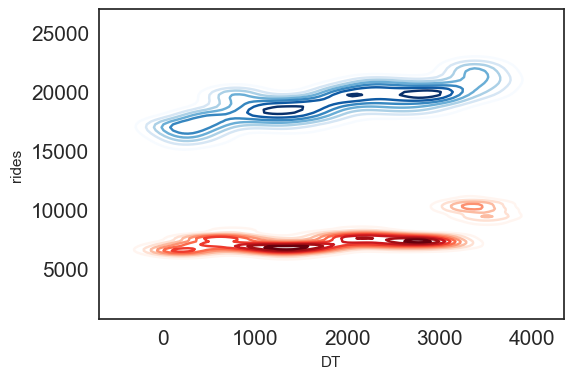

In [4]:
stat1 = 40380
stat2 = 40200
winsize = 3650
endD = '2016-06-30'
endD = pd.to_datetime(endD)
startD = endD - datetime.timedelta(days=winsize)
dayscheck = endD - startD
#dayscheck.days
dmask = (Ldata['station_id']==stat1) & (Ldata['daytype']=='W') & (Ldata['date'] >= startD) & (Ldata['date'] <= endD)  
Lsub = Ldata.loc[dmask]
Lsub['DT'] = Lsub['date']-startD
Lsub['DT'] = Lsub['DT'].astype('timedelta64[D]').astype(np.float64)

dmask = (Ldata['station_id']==stat2) & (Ldata['daytype']=='W') & (Ldata['date'] >= startD) & (Ldata['date'] <= endD)  
Lsub2 = Ldata.loc[dmask]
Lsub2['DT'] = Lsub2['date']-startD
Lsub2['DT'] = Lsub2['DT'].astype('timedelta64[D]').astype(np.float64)

display(Lsub.head(2),Lsub.tail(2))
with sns.axes_style("white"):
    sns.kdeplot(Lsub.DT, Lsub.rides, cmap='Blues', n_levels=10, shade=False, shade_lowest=False);
    sns.kdeplot(Lsub2.DT, Lsub2.rides, cmap='Reds', n_levels=10, shade=False, shade_lowest=False);


Machinery for looping over various time windows; no computations are being done in the loop here yet.

In [5]:
maxn = 10
minn = 0
testi = 40380
winshift = 60
winsize = 90
initD = '2014-01-01'

index = list(range(minn,maxn))
cols = ['startdate','enddate']

initD = pd.to_datetime(initD)
timedf = pd.DataFrame(index = index, columns = cols)

for i in range(0,maxn):
    startD = initD + datetime.timedelta(days=i*winshift)
    endD = startD + datetime.timedelta(days=winsize)
    timedf.ix[i,['startdate','enddate']] = [startD, endD]
    
    dmask = (Ldata['station_id']==testi) & (Ldata['daytype']=='W') & (Ldata['date'] >= startD) & (Ldata['date'] <= endD)  
    Lsub = Ldata.loc[dmask]
    
    #Computations for.... stuff
    
display(timedf.head(3))
display(Lsub.head(3))

,startdate,enddate
0,2014-01-01 00:00:00,2014-04-01 00:00:00
1,2014-03-02 00:00:00,2014-05-31 00:00:00
2,2014-05-01 00:00:00,2014-07-30 00:00:00


,station_id,stationname,date,daytype,rides,lat,lon
748942,40380,Clark/Lake,2015-06-25,W,22203,41.885737,-87.630886
748943,40380,Clark/Lake,2015-06-26,W,21326,41.885737,-87.630886
748946,40380,Clark/Lake,2015-06-29,W,21688,41.885737,-87.630886


Machinery for looping through stations and geographic grid for net commuter-density computations; simple, commuter-density model uses exponential distributions for walkers and cyclists and a log-normal distribution for taxi/car-service relative weighting and parameters of each distribution estimated using data from AASHTO (commuting in America 2013), Chicago's 2010-Census data and Velo'v data on urban cycling in Lyon, France.  Each station acts as a weighted commuter sink based on overall ridership and trends for each station. The symmetry of the distribution model should make the directionality of the data (entry vs exit) irrelevant.  For now, no effort is made to include the effects of barriers (the lake, river, etc..), i.e. distribution functions are taken to be radially symmetric.

The graphic below only shows the distribution for a single day.  Stations are color mapped according to the total # of rides.

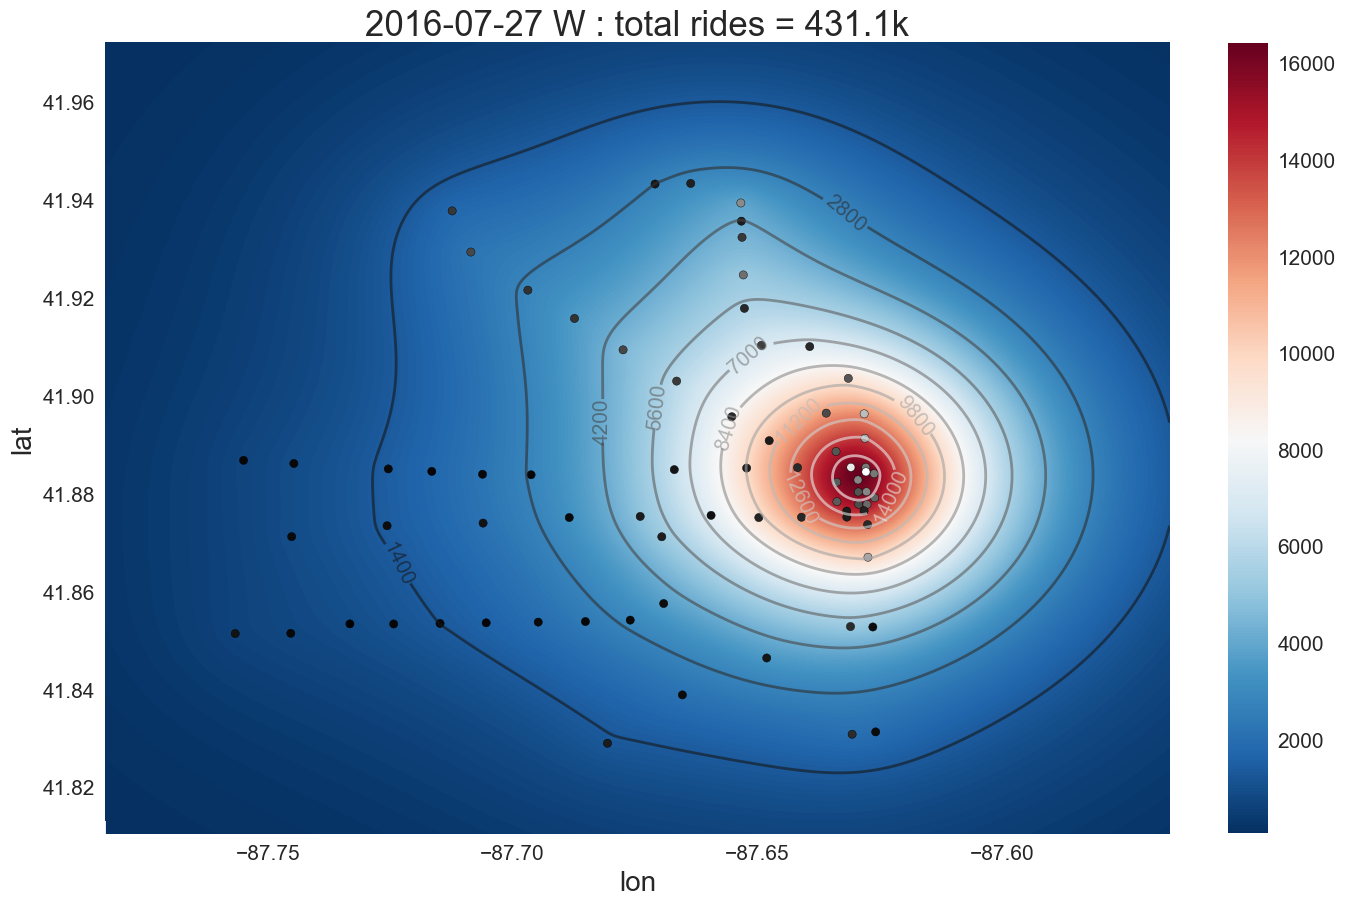

In [6]:
filtD = '2016-07-27'

#setting up xy and geo grids
xmin = -13; xmax = 5; ymin = -8; ymax = 10
Nx = 1800; Ny = 1800
x = np.linspace(xmin,xmax,Nx)
y = np.linspace(ymin,ymax,Ny)
xx, yy = np.meshgrid(x,y, sparse = False)
xdata = np.ndarray.flatten(xx)
ydata = np.ndarray.flatten(yy)
latdata, londata = geoconv(xdata, ydata, dslat, dslon)
lt = np.reshape(latdata,(Ny,Nx))
ln = np.reshape(londata,(Ny,Nx))

#perform any desired masking
dmask = (Ldata['date'] == filtD) & (Ldata['rides'] > 0)
Lsubmap = Ldata.loc[dmask]

zdata = np.zeros(Nx*Ny)

#iterating through gridpoints (*note: this method was built out prior to the vectorization work in the next section; 
#vectorizing this would be relatively straightforward now)
wsum = 0
for row in Lsubmap.itertuples():
    wz = row[5]; lati = row[6]; loni = row[7];
    zdata = zdata + wz*cdens(londata, latdata, loni, lati)
    wsum = wsum + wz

zz = np.reshape(zdata,(Ny,Nx))
zmin = 0; Ncon = 12;
dz = int(np.ceil((np.max(zz)-zmin)/Ncon/100.0))*100

plt.figure(figsize=(15,15))
cdensmap = plt.pcolormesh(ln,lt,zz, cmap = 'RdBu_r')
cdensmap.axes.set_ylim(np.min(lt), np.max(lt))
cdensmap.axes.set_xlim(np.min(ln), np.max(ln))
cset = plt.contour(ln, lt, zz, np.arange(zmin,np.max(zz),dz),linewidths=2,cmap='gray',alpha = 0.6)
plt.clabel(cset,inline=True,fmt='%1.0f',fontsize=15)
plt.colorbar(cdensmap, fraction=0.034)
plt.title(filtD + " " + str(Lsubmap.iloc[0]['daytype']) + " : total rides = " + str(np.around(wsum/1000,1))+"k", fontsize=25)
plt.xlabel('lon', fontsize=20)
plt.ylabel('lat', fontsize=20)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(Lsubmap.lon.values,Lsubmap.lat.values, s= 35, c=Lsubmap.rides.values, cmap ='gray')

Alternative method that estimates commuter density based on a simple decision model.  In this model, every hypothetical rider at a given geographic location will go to the closest station.  This defines a fixed area over which the riders for a given station must be distributed.  Knowing this area and the total # of rides, we can compute an average commuter density with better granularity than in the case of the approach above, which uses a trip-distance PDF.

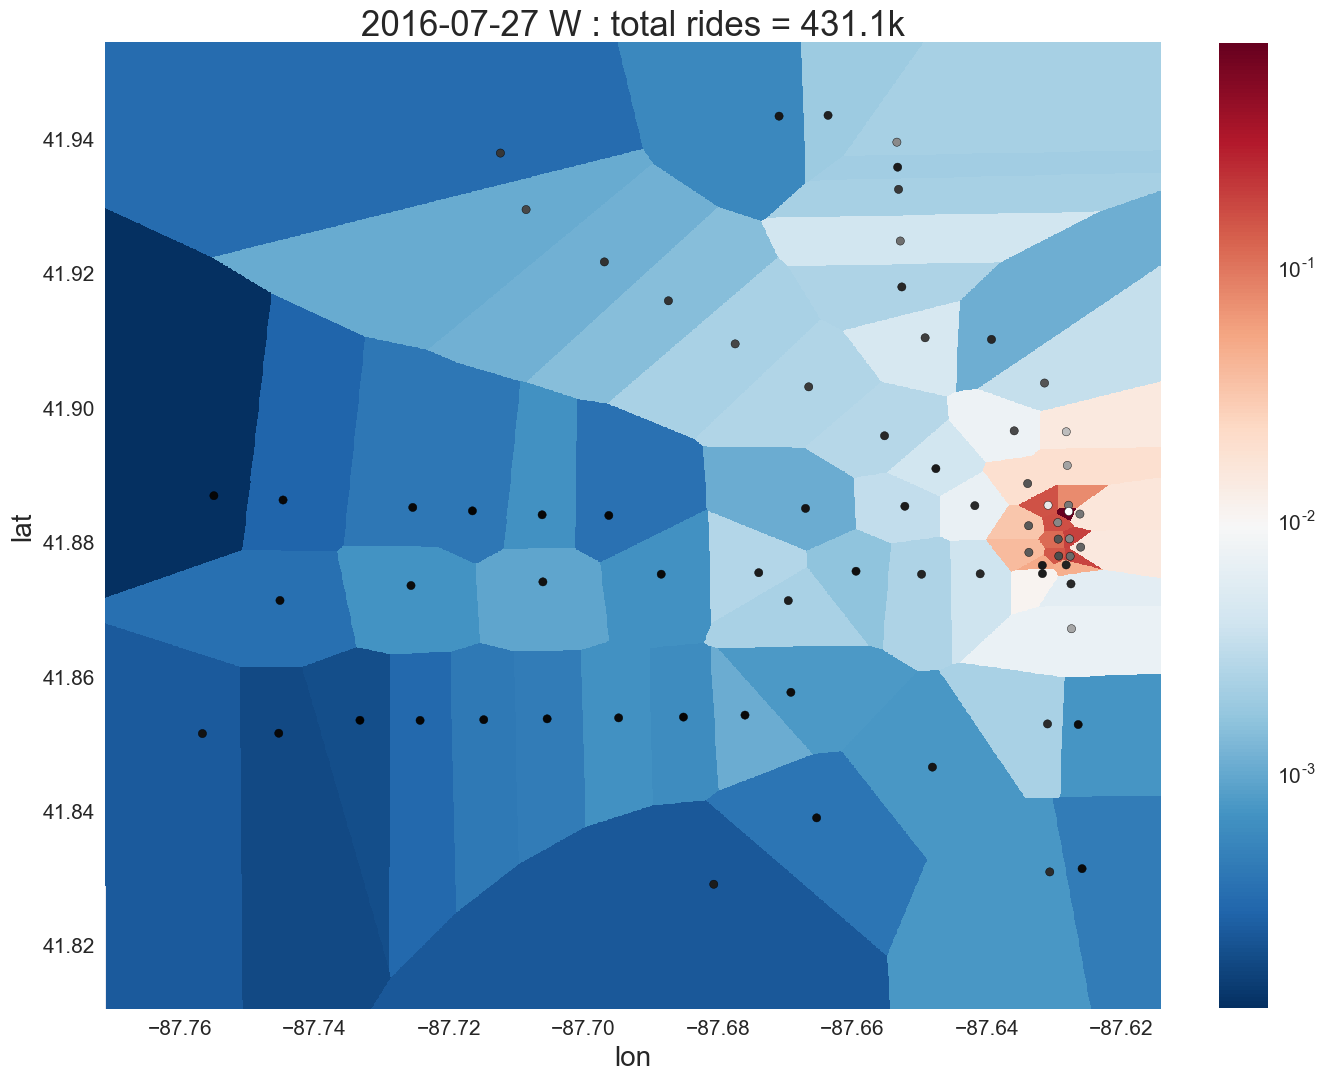

In [7]:
#setting up xy and geo grids
xmin = -12; xmax = 1; ymin = -8; ymax = 8
Nx = 1300; Ny = 1600
#xmin = -1.5; xmax = 0.5; ymin = -1; ymax = 1
#Nx = 1000; Ny = 1000
dA = ((xmax-xmin)*1000./Nx)**2
x = np.linspace(xmin,xmax,Nx)
y = np.linspace(ymin,ymax,Ny)
xx, yy = np.meshgrid(x,y, sparse = False)
xdata = np.ndarray.flatten(xx)
ydata = np.ndarray.flatten(yy)
latdata, londata = geoconv(xdata, ydata, dslat, dslon)
lt = np.reshape(latdata,(Ny,Nx))
ln = np.reshape(londata,(Ny,Nx))

#setting up station and grid geo data for distance computation
latmat = np.asmatrix(Lsubmap.lat.values); lonmat = np.asmatrix(Lsubmap.lon.values)
latM = np.asmatrix(latdata).transpose(); lonM = np.asmatrix(londata).transpose()

#vectorized computation of distances and determination of closest station for a given grid point; adding rides col as well 
clustDF = pd.DataFrame(np.argmin(nphaversine(latM,lonM,latmat,lonmat),1),columns=['clusterID'])
clustDF['rides'] = np.asarray(Lsubmap.iloc[clustDF['clusterID'],4])

#counting up how many grid points (i.e. how much area) have been assigned to each station; building dictionary for mapping
gclust = clustDF.groupby('clusterID').size()
scale = dict(zip(gclust.index, gclust))

#mapping the appropriate commuter density to each point
clustDF['density'] = clustDF['rides']/clustDF['clusterID'].map(scale)/dA
clustzz = np.reshape(clustDF['density'],(Ny,Nx))

zmin = 0; Ncon = 12;
dz = int(np.ceil((np.max(clustzz)-zmin)/Ncon/100.0))*100

plt.figure(figsize=(15,15))
cdensmap = plt.pcolormesh(ln,lt,clustzz, cmap = 'RdBu_r', norm=LogNorm())
cdensmap.axes.set_ylim(np.min(lt), np.max(lt))
cdensmap.axes.set_xlim(np.min(ln), np.max(ln))
#cset = plt.contour(ln, lt, clustzz, np.arange(zmin,np.max(clustzz),dz),linewidths=2,cmap='gray',alpha = 0.6)
#plt.clabel(cset,inline=True,fmt='%1.0f',fontsize=15)
plt.colorbar(cdensmap, fraction=0.0415)
plt.title(filtD + " " + str(Lsubmap.iloc[0]['daytype']) + " : total rides = " + str(np.around(wsum/1000.,1))+"k", fontsize=25)
plt.xlabel('lon', fontsize=20)
plt.ylabel('lat', fontsize=20)

plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(Lsubmap.lon.values,Lsubmap.lat.values, s= 35, c=Lsubmap.rides.values, cmap ='gray')

Just a duplicate of the previous cell to see a zoomed-in view of the loop.

Next up is probably to score each location by looking at the temporal variance and trend.  After that I'll work on importing Chicago's census tracts to begin developing a "value map" based on a variety of economic metrics.  Also on the GIS front, it should be reasonably straightforward to enforce zero commuter density in the lake.

In [9]:
# Code for scoring geographic grid points based on property values - values at either extreme are 
# penalized with an appropriate structure 

In [10]:
# Convolution of weighted commuter-density map and property-score map gives suggestions for optimum
# locations.  Method can be extended with other data, e.g. divvy locations, bus and METRA data, 
# crime statistics; additional filtering of candidate locations in consultation with client